In [1]:
%matplotlib inline

/Users/nhdaly/anaconda2/envs/p2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
FFMPEG_BIN = 'ffmpeg'
frame_width  = 48
frame_height = 54
frame_depth  =  3 # (number of colors)
frame_dim = (frame_height, frame_width, frame_depth)  # height x width x num_colors(depth)

In [4]:
import subprocess as sp
command = [ FFMPEG_BIN,
            '-i', 'fareeds_take.2015.09.21.speech.full_res.crop.048x054.mov',
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
video_pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

In [5]:
# Import the movie file into a python array of images.

from IPython import display

frames = []
while video_pipe:
    # read 1 frame bytes
    raw_image = video_pipe.stdout.read(frame_dim[0]*frame_dim[1]*frame_dim[2])
    if not raw_image:
        break
    # transform the byte read into a numpy array
    image =  np.fromstring(raw_image, dtype='uint8')
    image = image.reshape(frame_dim)
    frames.append(image)
    # throw away the data in the pipe's buffer.
    video_pipe.stdout.flush()
    
len(frames)

4740

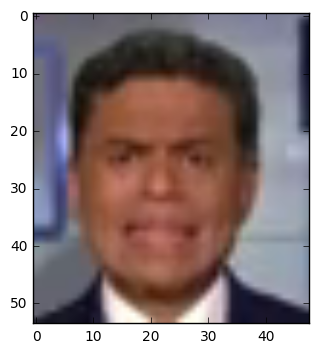

In [6]:
def play_frames_clip(frames):
    ''' frames -- a list/array of np.array images. Plays all frames in the notebook as a clip.'''
    for frame in frames:
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)

play_frames_clip(frames[10:20])

In [7]:
np.random.random()

0.015151745119684423

In [8]:
# True means it came from the GAN (it was generated).
false_frames  = frames
#false_frames  = [normalize(x) for x in frames]
noise_frames  = [np.random.random(frames[0].shape) * 255 for _ in range(len(frames))]
solid_frames  = [np.zeros(frames[0].shape) + (np.random.random()*255) for _ in range(len(frames))]
true_frames = solid_frames

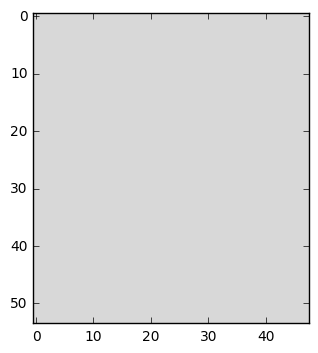

In [9]:
play_frames_clip(true_frames[10:20])

In [10]:
labelled_inputs = [(x.flatten(),1) for x in true_frames] + [(x.flatten(),0) for x in false_frames]
np.random.shuffle(labelled_inputs)

In [11]:
num_total_inputs = len(labelled_inputs)

train_inputs = labelled_inputs[0:num_total_inputs*6/10]
cv_inputs    = labelled_inputs[num_total_inputs*6/10:num_total_inputs*8/10]
test_inputs  = labelled_inputs[num_total_inputs*8/10:]

Xtrain = [x for x,y in train_inputs]
ytrain = [y for x,y in train_inputs]
Xcv    = [x for x,y in cv_inputs]
ycv    = [y for x,y in cv_inputs]
Xtest  = [x for x,y in test_inputs]
ytest  = [y for x,y in test_inputs]

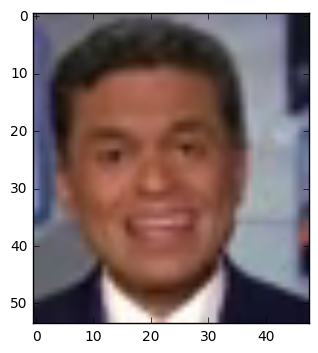

In [12]:
play_frames_clip([x.reshape(frame_dim) for x in Xtrain[10:20]])

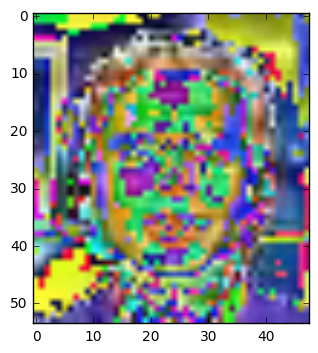

In [13]:
def normalize(x):
    mu = np.mean(x)
    sigma = np.std(x)
    x_norm = (x - mu) / sigma  # All element-wise
    return x_norm
play_frames_clip([normalize(x) for x in frames[30:40]])

### Build the Discriminator

In [14]:
import tensorflow as tf

In [15]:
flattened_image_len = frames[0].flatten().shape[0]
dim_X  = flattened_image_len
dim_h1 = 10
dim_h2 = 5
dim_h3 = 5
dim_y  = 1

In [16]:
print flattened_image_len
W1 = tf.Variable(tf.random_uniform([dim_X,dim_h1], maxval=0.1, minval=-0.1), name='W1') 
b1 = tf.Variable(tf.zeros([dim_h1]), name='b1')

Wy = tf.Variable(tf.random_uniform([dim_h1,dim_y], maxval=0.1, minval=-0.1), name='W3') 
by = tf.Variable(tf.zeros([dim_y]), name='by')

W2 = tf.Variable(tf.random_uniform([dim_h1,dim_h2], maxval=0.1, minval=-0.1), name='W2') 
b2 = tf.Variable(tf.zeros([dim_h2]), name='b2')
W3 = tf.Variable(tf.random_uniform([dim_h2,dim_h3], maxval=0.1, minval=-0.1), name='W3') 
b3 = tf.Variable(tf.zeros([dim_h3]), name='b3')


7776


In [17]:
X = tf.placeholder(tf.float32, [None, flattened_image_len], name='images') # Images (in a batch)
a1 = X
a2 = tf.nn.sigmoid(tf.matmul(a1, W1) + b1)
print a2.get_shape()

ay = tf.nn.sigmoid(tf.matmul(a2, Wy) + by)
y = ay        # Confidence the image is generated by GAN.

print y.get_shape()


a3 = tf.nn.sigmoid(tf.matmul(a2, W2) + b2)
a4 = tf.nn.sigmoid(tf.matmul(a3, W3) + b3)


(?, 10)
(?, 1)


In [18]:
truth = tf.placeholder(tf.float32, [None], name='truth')


m = tf.shape(truth)  # Number of input pairs.

#cost = tf.reduce_mean(tf.reduce_sum(-truth*tf.log(y) - (1-truth)*tf.log(1-y)));  # multiplication is element-wise
cost_unreg = (1./tf.to_float(m))*tf.reduce_sum(tf.reduce_sum(-truth*tf.log(y + 1e-10) - (1-truth)*tf.log(1-y + 1e-10)));  # multiplication is element-wise

reg_lambda = tf.placeholder(tf.float32, 1, name='lambda')

theta_sums = tf.reduce_sum(W1**2) + tf.reduce_sum(W2**2) + tf.reduce_sum(W3**2) + tf.reduce_sum(Wy**2)
cost_reg   = cost_unreg + (reg_lambda / (2*tf.to_float(m))) * theta_sums

In [39]:
learning_rate = 0.001
sess = tf.Session()


In [40]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_reg)

In [42]:
def trainLogisticRegression(Xtrain, ytrain, regularization_lambda):
    global sess
    init = tf.initialize_all_variables()
    sess.run(init)
    losses = []
    ys = []
    iteration = 0
    for i in range(100):
        normalized_inputs = Xtrain
        labels = ytrain

        feed_dict={X:normalized_inputs, truth:labels, reg_lambda:[regularization_lambda]}
        _,[loss],y_out = sess.run((train_step, cost_reg, y), feed_dict=feed_dict)
        losses.append(loss)
        ys.append(y_out.flatten())
        iteration += 1
    return losses, ys

losses,ys = trainLogisticRegression(Xtrain[:50], ytrain[:50], 10)

TypeError: Fetch argument 1 has invalid type <type 'int'>, must be a string or Tensor. (Can not convert a int into a Tensor or Operation.)

In [ ]:
print losses[:5]
print ys[0].shape
print losses[-5:]
print np.max(losses)
print np.min(losses)

In [23]:
plt.plot(losses[:100])

NameError: name 'losses' is not defined

## Let's look at the Learning Curves to diagnose what's wrong!

In [24]:
def logisticRegressionCostFunction(input_pairs, regularization_lambda):
    normalized_inputs = np.array([normalize(x[0]) for x in input_pairs])
    labels = np.array([x[1] for x in input_pairs])

    feed_dict={X:normalized_inputs, truth:labels, reg_lambda:[regularization_lambda]}
    [loss], y_out = sess.run((cost_reg,y), feed_dict=feed_dict)
    return loss
loss = logisticRegressionCostFunction(Xtrain[:200], 2)
print loss

/Users/nhdaly/anaconda2/envs/p2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


ValueError: Cannot feed value of shape (200,) for Tensor u'images:0', which has shape '(?, 7776)'

In [25]:
# Plot how well it can learn 

In [26]:
regularization_lambda = 100
error_train = []
error_val = []
subset_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 100000]
for idx,subset_size in enumerate(subset_sizes):
    train_subset = Xtrain[:subset_size]
    _ = trainLogisticRegression(train_subset, regularization_lambda)
    
    # Now calculate the loss for the theta trained with this training subset.
    #  Note, don't regularize when calculating actual loss.
    error_train.append(logisticRegressionCostFunction(train_subset, 0))
    error_val.append(logisticRegressionCostFunction(Xcv, 0))
    print "Training with subset of size {0} -- error_train: {1}, error_val: {2}".format(subset_size, error_train[-1], error_val[-1])

    plt.plot(subset_sizes[:idx+1], error_train, subset_sizes[:idx+1], error_val)
    display.display(plt.gcf())
    display.clear_output(wait=True)


/Users/nhdaly/anaconda2/envs/p2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


ValueError: Cannot feed value of shape (10,) for Tensor u'images:0', which has shape '(?, 7776)'

In [27]:
print subset_sizes
print error_train
print error_val

[10, 50, 100, 500, 1000, 5000, 10000, 100000]
[]
[]


Now I have enough data that the problem is high bias. Also, note that the error for cross validation set hardly changes with subset_size. This means I have high bias, I think.

## Let's do all that, but this time with SciKit Learn!
It's magic!!!

In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [30]:
lr.fit(Xtrain, ytrain)
lr.score(Xcv, ycv)

1.0

array([0])

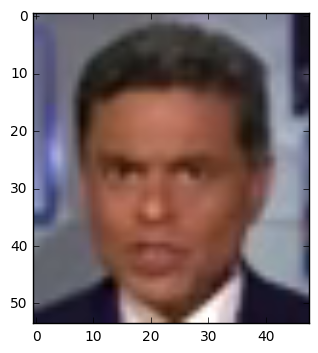

In [31]:
images = Xcv[10:11]
play_frames_clip([x.reshape(frame_dim) for x in images])

lr.predict(images)

In [32]:
import sklearn.metrics

sklearn.metrics.r2_score(ycv, lr.predict(Xcv))

1.0

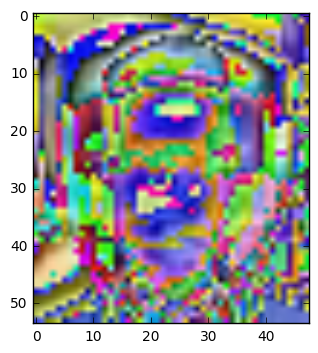

In [33]:
weights = lr.coef_.reshape(frame_dim)
play_frames_clip([normalize(weights)])

In [ ]:
import sklearn.learning_curve
sklearn.learning_curve.learning_curve(lr,
                                      [x for x,y in labelled_inputs],
                                      [y for x,y in labelled_inputs])

In [ ]:
# Down-scale the image.
import scipy
import scipy.misc
new_shape = np.array(image.shape) / 3
new_shape[2] = 3
small_image = scipy.misc.imresize(image, new_shape)

In [ ]:
plt.imshow(small_image)
small_image.shape